In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/drive/MyDrive/dl_dataset.zip
!ls -lah

total 265M
drwxr-xr-x 1 root root 4.0K Jun 13 10:07 .
drwxr-xr-x 1 root root 4.0K Jun 13 09:21 ..
drwxr-xr-x 4 root root 4.0K Jun  9 13:38 .config
drwxr-xr-x 4 root root 4.0K Jun 13 09:38 dl_dataset
-rw-r--r-- 1 root root  64M Jun 13 09:48 dl_dataset.zip
drwx------ 5 root root 4.0K Jun 13 09:37 drive
drwxr-xr-x 2 root root 4.0K Jun 13 09:32 .ipynb_checkpoints
drwxr-xr-x 4 root root 4.0K Jun 13 09:44 logs
drwxr-xr-x 1 root root 4.0K Jun  9 13:39 sample_data
drwxr-xr-x 4 root root 4.0K Jun 13 10:03 unetModel
-rw-r--r-- 1 root root 201M Jun 13 10:07 unetModel.zip


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

dirpath = "/content/dl_dataset"

import os
for dirname, _, filenames in os.walk(dirpath):
    print(f"[INFO] importing directory: {dirname}\n")
    with tqdm(total=len(filenames)) as t:
        for filename in filenames:
            t.update(1)

[INFO] importing directory: /content/dl_dataset



0it [00:00, ?it/s]


[INFO] importing directory: /content/dl_dataset/Image



100%|██████████| 290/290 [00:00<00:00, 794479.53it/s]


[INFO] importing directory: /content/dl_dataset/Mask



100%|██████████| 290/290 [00:00<00:00, 905694.83it/s]


[INFO] importing directory: /content/dl_dataset/Mask/.ipynb_checkpoints



0it [00:00, ?it/s]


In [ ]:
import tensorflow as tf
from keras.models import Model

from tqdm import tqdm
from skimage.color import rgb2gray as rtg
from skimage.io import imread, imshow
from skimage import io
io.use_plugin('matplotlib')
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.morphology import label
from PIL import Image

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Reshape
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
imagesPath = dirpath + "/Image"
masksPath = dirpath + "/Mask"

print(imagesPath)

/content/dl_dataset/Image


In [ ]:
images_ids = next(os.walk(imagesPath))[2]
masks_ids = next(os.walk(masksPath))[2]

In [ ]:
print(f"Total images: {len(images_ids)}\nTotal masks: {len(masks_ids)}")

Total images: 290
Total masks: 290


In [ ]:
N = 512

In [ ]:
X = np.zeros((len(images_ids), N, N, 3), dtype=np.uint8)
Y = np.zeros((len(masks_ids), N, N, 1), dtype=np.bool_)

In [ ]:
print("Resizing training images and masks")
for n, id_ in tqdm(enumerate(images_ids), total=len(images_ids)):
    path = imagesPath + "/" + id_
    img = Image.open(path)
    img = np.array(img)
    img = resize(img, (N, N, 3), mode="constant", preserve_range=True)
    X[n] = img
    mask = np.zeros((N, N, 1), dtype=np.bool_)
    mask = imread(masksPath + "/" + id_.split(".")[0] + ".png")
    mask = np.expand_dims(resize(mask, (N, N), mode="constant", preserve_range=True), axis=-1)
    Y[n] = mask


Resizing training images and masks


100%|██████████| 290/290 [01:29<00:00,  3.26it/s]


In [ ]:
print(f"X.shape: {X.shape}\nY.shape: {Y.shape}")

X.shape: (290, 512, 512, 3)
Y.shape: (290, 512, 512, 1)


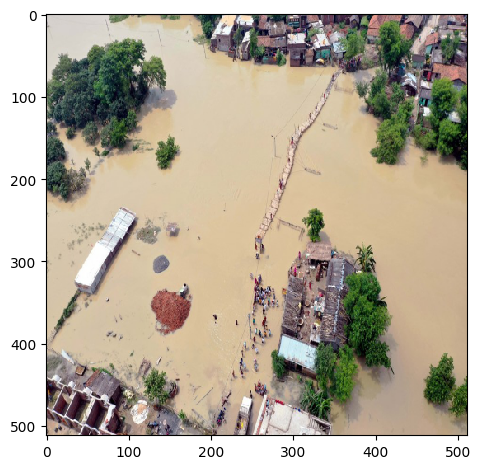

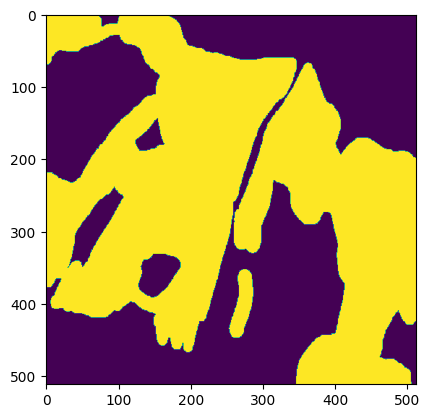

In [ ]:
import random
io.use_plugin('matplotlib')
image_x = random.randint(0, len(images_ids))
imshow(X[image_x])
plt.show()
plt.imshow(np.squeeze(Y[image_x]))

In [ ]:
# The custom U-Net Architecture

# Input image
input = tf.keras.layers.Input((N, N, 3))

# reduce image config
s = tf.keras.layers.Lambda(lambda x: x / N)(input)

# block 1
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# block 2
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# block 3
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3  = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# block 4
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

# block 5
c5 = tf.keras.layers.Conv2D(N, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(N, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(N, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

# block 6
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# block 7 - back 1
u7 = tf.keras.layers.Conv2DTranspose(N, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(N, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(N, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(N, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# block 8 - back 2
u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# block 9 - back 3
u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# block 10 - back 4
u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

# block 11 - back 5
u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1])
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

modelUNet = tf.keras.Model(inputs=input, outputs=outputs, name='U-NET')

modelUNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
modelUNet.summary()

Model: "U-NET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
callbacks=[
#     tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs")]


results = modelUNet.fit(X, Y, validation_split=0.1, batch_size=8, epochs=55, callbacks=callbacks)

Epoch 1/55
33/33 [==============================] - 59s 818ms/step - loss: 0.6861 - accuracy: 0.6091 - val_loss: 0.6114 - val_accuracy: 0.7406
Epoch 2/55
33/33 [==============================] - 19s 575ms/step - loss: 0.5533 - accuracy: 0.7478 - val_loss: 0.4728 - val_accuracy: 0.8341
Epoch 3/55
33/33 [==============================] - 19s 588ms/step - loss: 0.5128 - accuracy: 0.7656 - val_loss: 0.5315 - val_accuracy: 0.7400
Epoch 4/55
33/33 [==============================] - 20s 593ms/step - loss: 0.4847 - accuracy: 0.7778 - val_loss: 0.3696 - val_accuracy: 0.8485
Epoch 5/55
33/33 [==============================] - 20s 610ms/step - loss: 0.4502 - accuracy: 0.7968 - val_loss: 0.3725 - val_accuracy: 0.8488
Epoch 6/55
33/33 [==============================] - 20s 615ms/step - loss: 0.4722 - accuracy: 0.7915 - val_loss: 0.3432 - val_accuracy: 0.8605
Epoch 7/55
33/33 [==============================] - 20s 601ms/step - loss: 0.4342 - accuracy: 0.8030 - val_loss: 0.3469 - val_accuracy: 0.8611

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

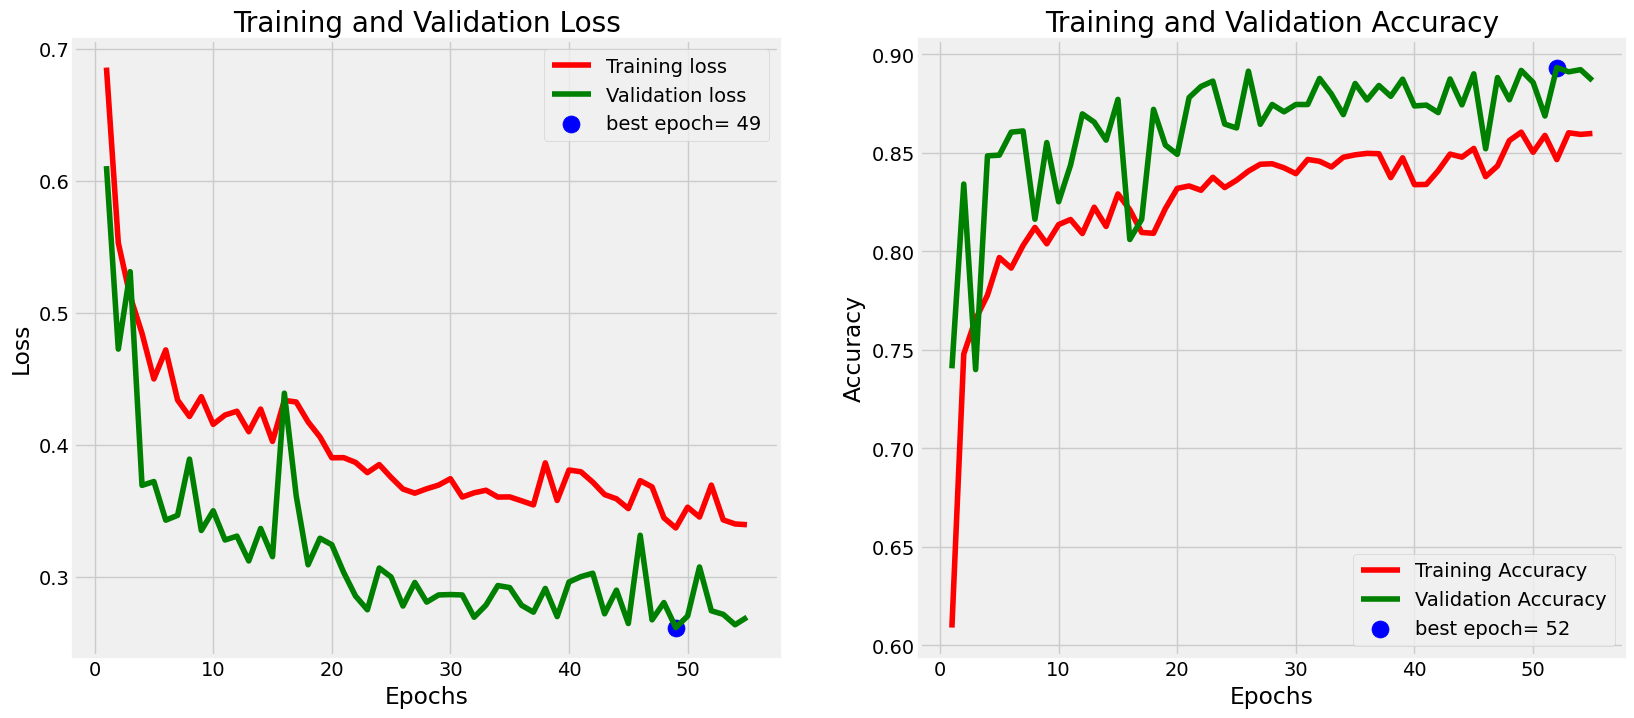

In [ ]:
plot_training(results)

In [ ]:
modelUNet.evaluate(X, Y)

10/10 [==============================] - 17s 585ms/step - loss: 0.3356 - accuracy: 0.8579


[0.33555367588996887, 0.8579282164573669]

In [ ]:
modelUNet.save("unetModel")

In [ ]:
!zip -r unetModel.zip unetModel


  adding: unetModel/ (stored 0%)
  adding: unetModel/keras_metadata.pb (deflated 95%)
  adding: unetModel/saved_model.pb (deflated 90%)
  adding: unetModel/assets/ (stored 0%)
  adding: unetModel/variables/ (stored 0%)
  adding: unetModel/variables/variables.index (deflated 75%)
  adding: unetModel/variables/variables.data-00000-of-00001 (deflated 29%)
  adding: unetModel/fingerprint.pb (stored 0%)


In [ ]:
global model
model = tf.keras.models.load_model("unetModel")

2023-02-20 11:58:30.069528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 11:58:30.070036: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-20 11:14:50.178716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<Figure size 2160x2160 with 0 Axes>

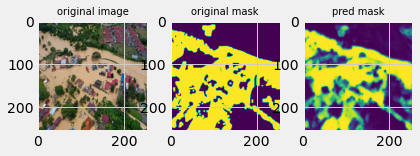

In [ ]:
plt.figure(figsize=(30,30))

ind = random.randint(0, len(X))
img = X[ind]
predMask = modelUNet.predict(np.expand_dims(img, axis=0), verbose=0)
fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("original image", fontdict = {'fontsize' : 10})
ax1.imshow(X[ind])
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("original mask", fontdict = {'fontsize' : 10})
ax2.imshow(np.squeeze(Y[ind]))
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("pred mask", fontdict = {'fontsize' : 10})
ax3.imshow(np.squeeze(predMask))